In [1]:
import os,glob
import numpy as np
import pandas as pd
import glob
import pyslha
import time
import progressbar as P
from atlas_susy_2018_13_Recast import getLLPs, getDisplacedJets
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import pyslha
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

delphesDir = os.path.abspath("./DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT

ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


Welcome to JupyROOT 6.28/06


True

In [2]:
inputFile = './pp2GoGo_strong/Events/run_01/strong_2000_850_tau_0.01_delphes_events.root'

In [3]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()

l_dec = []
r_dec = []
beta = []
gbeta  = []
mDV = []
nTracks = []
for ievt in range(nevts):    

    tree.GetEntry(ievt)
    llpCandidates = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters)
    for llp in llpCandidates:
        l_dec.append(np.sqrt(llp.Xd**2 + llp.Yd**2 + llp.Zd**2))
        r_dec.append(np.sqrt(llp.Xd**2 + llp.Yd**2))
        beta.append(llp.beta)
        gbeta.append(llp.gbeta)
        mDV.append(llp.mDV)
        nTracks.append(llp.nTracks)
    break


In [4]:
n = tree.bsmDirectDaughters.GetEntries()
for i in range(n):
    d = tree.bsmDirectDaughters.At(i)
    if abs(d.E-66.2038192) < 1e-4:
        print(d.PID,d.Status,d.E,d.M1,d.M2)

-321 1 66.20381927490234 -1 -1


In [5]:
n = tree.Particle.GetEntries()
for i in range(n):
    d = tree.Particle.At(i)
    if d.PID != -321:
        continue
    if abs(d.E-66.2038192) < 1e-4:
        print(d.PID,d.Status,d.E,d.M1,d.M2,d.D1,d.D2)

-321 1 66.20381927490234 753 756 -1 -1


In [4]:
llp = llpCandidates[0]
print(llp.PID)

1000023


In [4]:
print(len(llp._selectedDecays))

405


In [8]:
# Consistency checks:
pTot = np.array([llp.E,llp.Px,llp.Py,llp.Pz])
pNorm = np.linalg.norm(pTot)
for d in llp.finalDaughters:                
    pTot -= np.array([d.E,d.Px,d.Py,d.Pz])
    # print(d.PID,pTot)
print(pTot)

[-3.47262248e-05  5.53857535e-06 -1.17358286e-05  9.77478339e-06]


In [6]:
llp.mDV

536.2083881849927

In [7]:
pTot = np.zeros(4)
for d in llp._selectedDecays:
    if d.Charge == 0: continue
    p = np.array([0.,d.Px,d.Py,d.Pz])
    mpion = 0.140
    p[0] = np.sqrt(mpion**2 + np.dot(p[1:],p[1:]))
    if p[0] > 5e1:
        print(d.PID,d.Status,d.E)
    pTot = pTot + p
    
mDV = np.sqrt(pTot[0]**2 - np.dot(pTot[1:],pTot[1:]))
print(pTot)
print(mDV)

321 1 92.95435333251953
-321 1 66.20381927490234
-211 1 62.65273666381836
211 1 66.33820343017578
[ 632.71822815 -186.39606993 -267.61104745  -80.33525421]
536.2083881849927


In [18]:
pTot = np.zeros(4)
for d in llp.directDaughters:
    # if d.Charge == 0: continue
    p = np.array([0.,d.Px,d.Py,d.Pz])
    mpion = 0.140
    p[0] = np.sqrt(mpion**2 + np.dot(p[1:],p[1:]))
    if p[0] > 1e2:
        print(d.PID,d.Status)
    pTot = pTot + p
    
mDV = np.sqrt(pTot[0]**2 - np.dot(pTot[1:],pTot[1:]))
print(pTot)
print(mDV)

-3 23
-2 23
-1 23
[1979.77287693 -605.10147095 1447.94355965  856.922966  ]
849.9972544182796


In [5]:
l_dec = np.array(l_dec)
r_dec = np.array(r_dec)
beta = np.array(beta)
gbeta = np.array(gbeta)
mDV = np.array(mDV)
nTracks = np.array(nTracks)

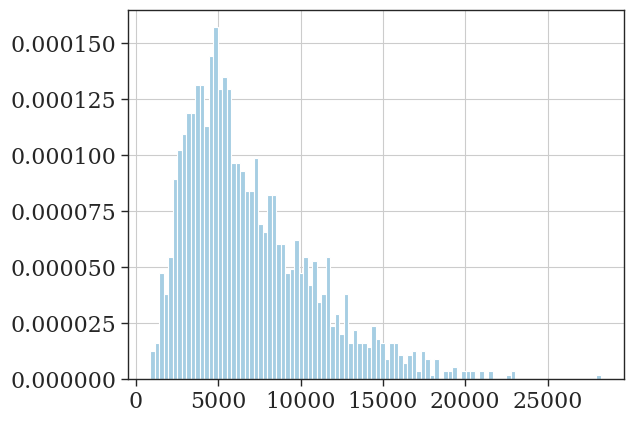

In [8]:
plt.hist(mDV,bins=100,density=True)
plt.grid()
plt.show()

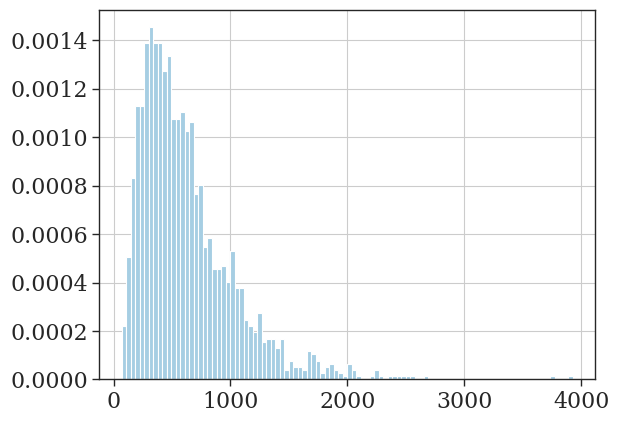

In [9]:
plt.hist(nTracks,bins=100,density=True)
plt.grid()
plt.show()

In [76]:
l0 = l_dec/gbeta

In [80]:
bins=np.linspace(0.,50,11)

In [81]:
def fDecayedAt(l0_mm,dl0_mm,tau_ns):
    c = 3e8*1e3 # (c in mm/s)
    tau = tau_ns*1e-9 # (proper lifetime in s)
    fDec = (dl0_mm/(c*tau))*np.exp(-l0_mm/(c*tau))
    return fDec # Fraction of particles which have decayed between l0 and l0+dl0

In [82]:
dl0_mm = bins[1]-bins[0]
tau_ns = 0.1
f = np.array([fDecayedAt(l,dl0_mm,tau_ns) for l in bins])

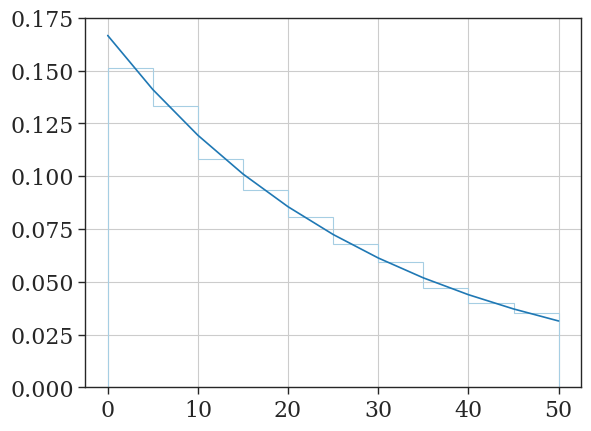

In [83]:
plt.hist(l0,bins=bins,density=False,histtype='step',weights=[1./len(l0)]*len(l0))
plt.plot(bins,f)
plt.grid()
plt.show()


In [52]:
gb_mean = np.mean(gbeta)
print(gb_mean)

0.621316422845395


In [53]:
Rmin = 4.0
c = 3e8*1e3 # (c in mm/s)
tau = tau_ns*1e-9 # (proper lifetime in s)
np.exp(-Rmin/(gb_mean*c*tau))

0.11695323174516004

In [54]:
len([l for l in l_dec if l > 4.0])/len(l_dec)

0.12082249349609765

In [57]:
len([l for l in r_dec if l > 4.0])/len(r_dec)

0.051280768461076646

In [59]:
print(len(r_dec))

19988


In [85]:
1-(1.-0.05)**2

0.09750000000000003